In [78]:
import xgboost
import timeit
import dataPreprocessing as dp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_validate

In [30]:
path = '/Users/nikhilsawal/OneDrive/machine_learning/data_science_case_studies/buildzoom/data/'

train_x = pd.read_table(path + 'train_data.csv')
test_x = pd.read_table(path + 'xtest_data.csv')
test_y = pd.read_csv(path + 'ytest_pred.csv')

In [103]:
train_x.type.value_counts()

ELECTRICAL                               28649
CONSTRUCTION / ADDITION OR ALTERATION    10939
POST ISSUANCE SUBMITTAL                   6507
SIDE SEWER                                6109
CONSTRUCTION / NEW CONSTRUCTION           4251
                                         ...  
M F EXP ROUTING                              2
GRADING ONLY                                 1
BOILER /                                     1
SEPA ONLY-RES                                1
GRADING EXPEDITE                             1
Name: type, Length: 94, dtype: int64

In [87]:
print(train_x.dtypes, test_x.shape)

licensetype         object
businessname        object
legaldescription    object
description         object
type                object
subtype             object
job_value           object
dtype: object (25149, 6)


In [4]:
X_train, y_train, X_test, y_test, X_val, y_val = dp.machine_learning_prep(train_x, test_x, test_y)


Make sure stratification works and we have equal split across train-val-test sets
Train split:  0.28604709985755555
Validation split:  0.28603378729182477
Test split:  0.2755686336885637




In [108]:
print(y_train.sum(), len(y_train))

21487 75117


# 1. Baseline model - Decision Tree

In [89]:
classifier = DecisionTreeClassifier(random_state=1002)
classifier = classifier.fit(X_train, y_train)

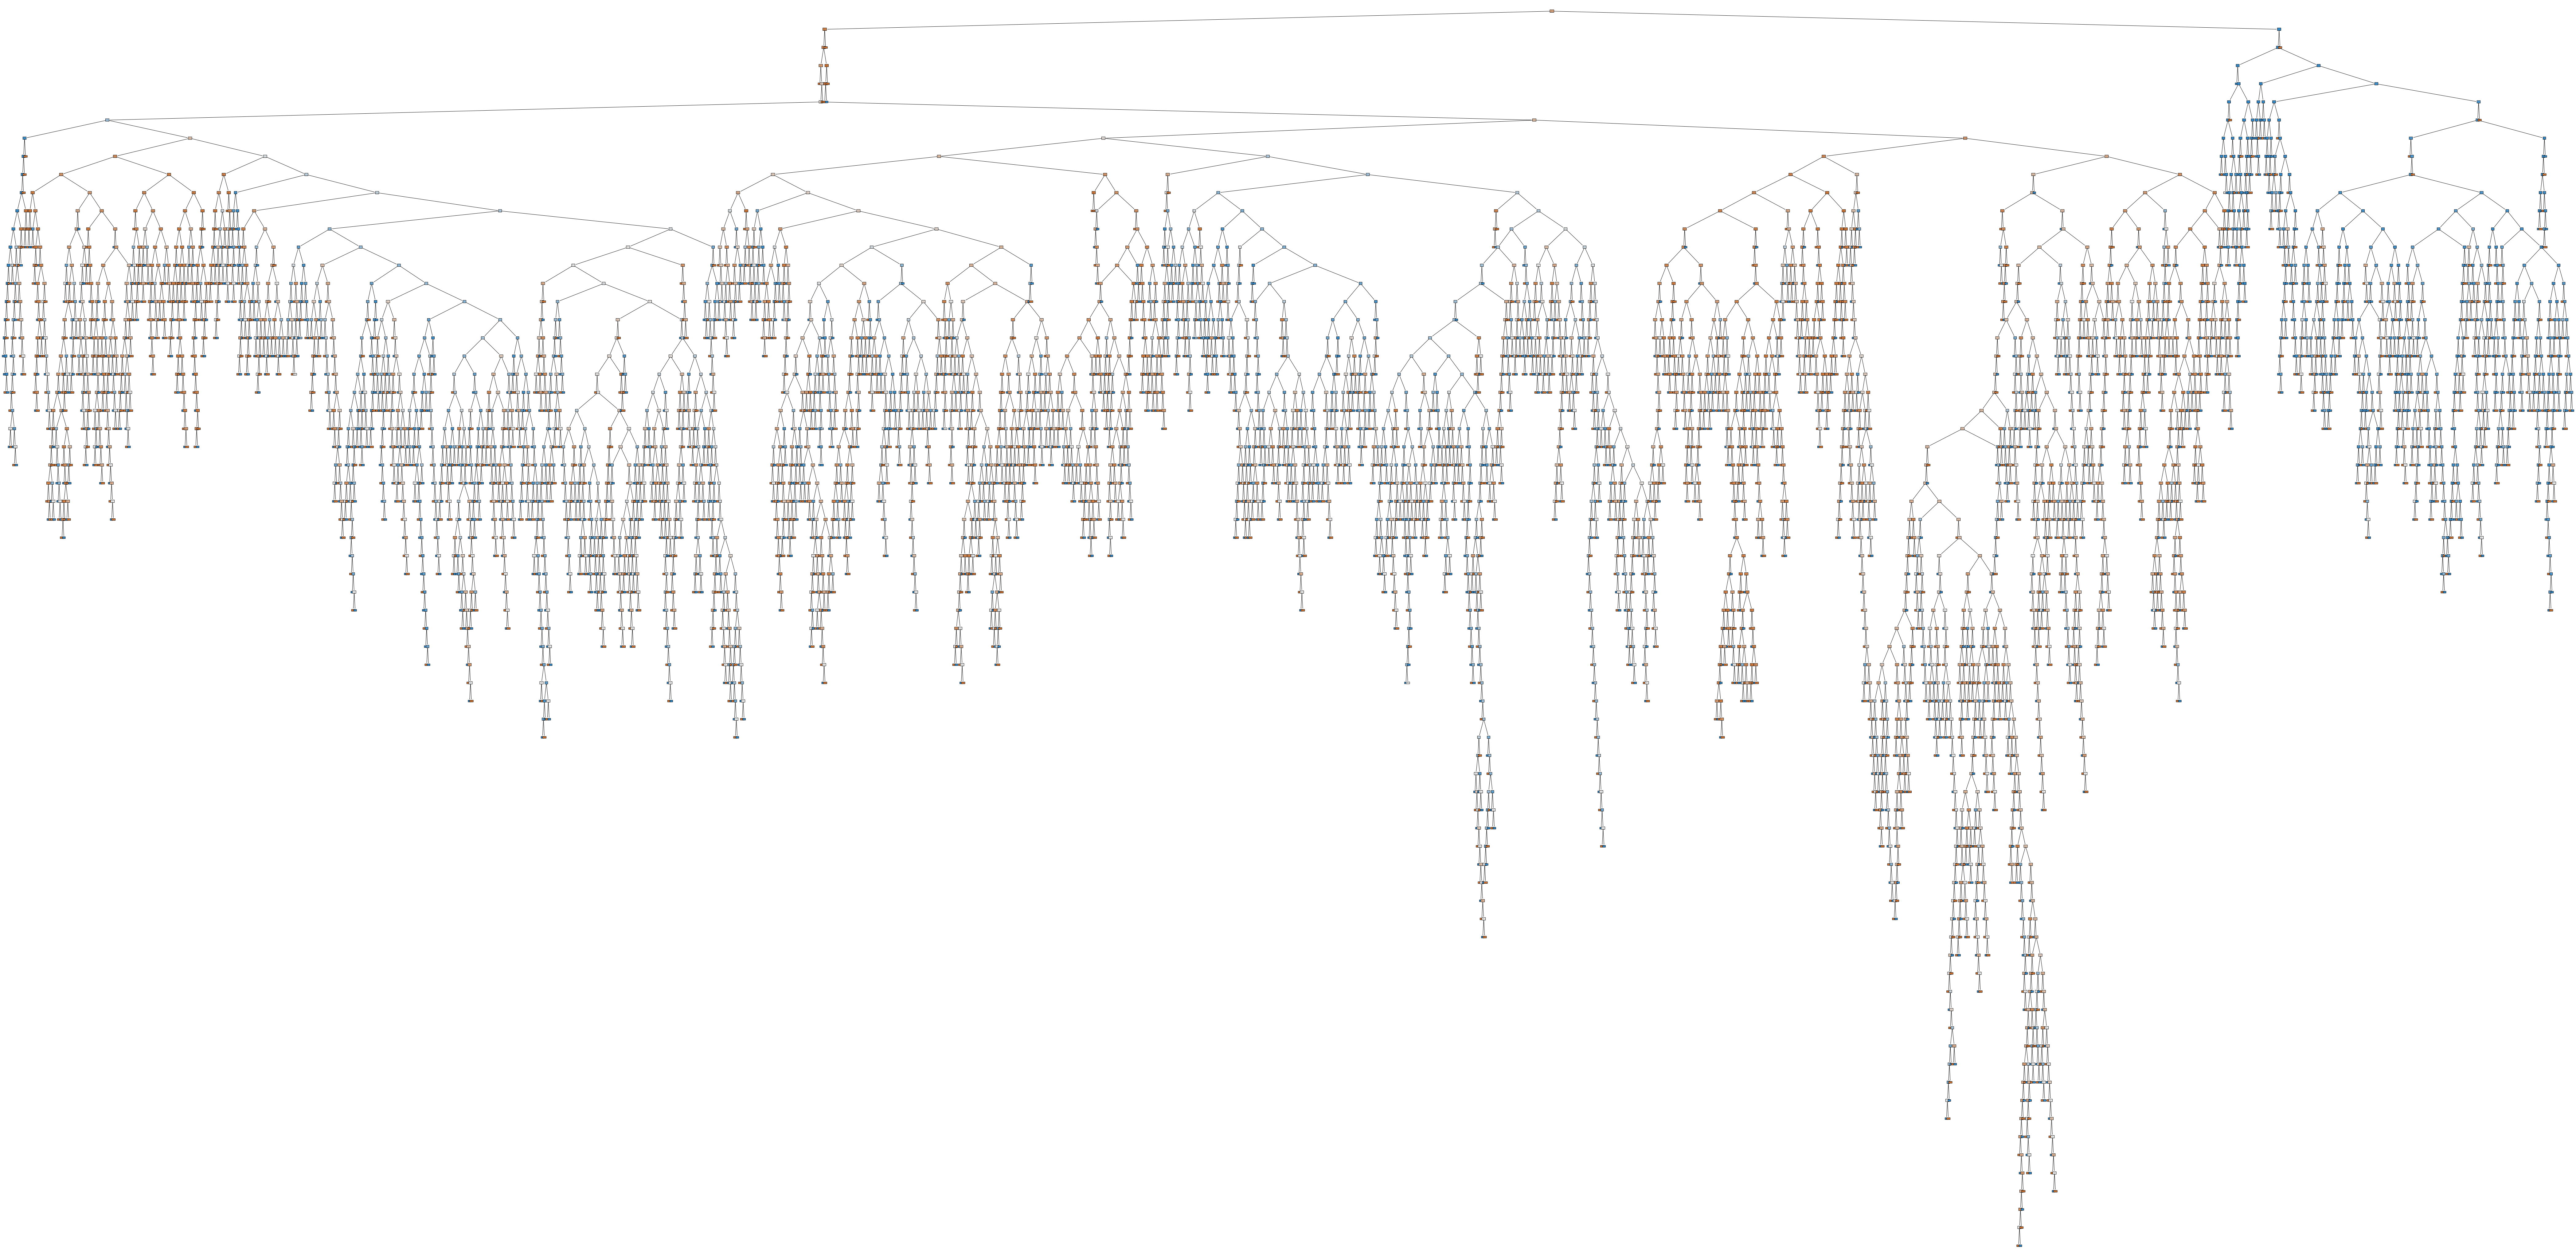

In [109]:
plt.figure(figsize=(150, 75))
plot_tree(classifier,
          filled=True,
          rounded=True,
          class_names=['Non-Electrical', 'Electrical'])
plt.show()

In [15]:
dp.get_scores(classifier, X_val, y_val, X_test, y_test)

Validation Set Metrics: 
-----------------------
Confusion matrix: 
 [[17245   632]
 [  656  6506]]

F1 Score:  0.90993006993007

Precision:  0.9114597926590081

Accuracy:  0.9485602460162147

Recall/Sensitivity:  0.9084054733314717

Specificity:  0.964647312188846


Test Set Metrics: 
-----------------
Confusion matrix: 
 [[13980  4238]
 [ 4063  2867]]

F1 Score:  0.40855005343783396

Precision:  0.40351864883884586

Accuracy:  0.6699141084778114

Recall/Sensitivity:  0.4137085137085137

Specificity:  0.7673729278735316


# 2. Cost Complexity Pruning

In [53]:
path = classifier.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

In [54]:
start = timeit.default_timer()

alpha_loop_values = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=10, ccp_alpha=ccp_alpha)
    scores = cross_validate(clf_dt, X_train, y_train, cv=3, scoring=['precision', 'recall'])
    alpha_loop_values.append([ccp_alpha, np.mean(scores['test_precision']), np.std(scores['test_precision']),
                              np.mean(scores['test_recall']), np.std(scores['test_recall'])])

stop = timeit.default_timer()
print(stop-start)

alpha_results = pd.DataFrame(alpha_loop_values, 
                             columns=['alpha', 'mean_precision', 'std_precision', 'mean_recall', 'std_recall'])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2761.4307103890005


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


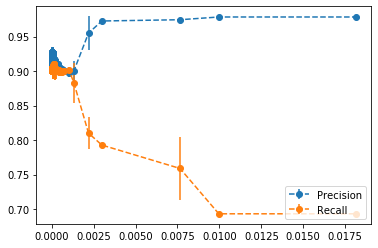

In [60]:
alpha_results = alpha_results[:-1]

plt.errorbar(x=alpha_results['alpha'], 
             y=alpha_results['mean_precision'], 
             yerr=alpha_results['std_precision'],
             marker='o',
             linestyle='--',
              label='Precision')

plt.errorbar(x=alpha_results['alpha'], 
             y=alpha_results['mean_recall'], 
             yerr=alpha_results['std_recall'],
             marker='o',
             linestyle='--',
             label='Recall')

plt.legend(loc='lower right')

In [82]:
alpha_results[(alpha_results['alpha'] > 0.001) & (alpha_results['alpha'] < 0.0025)]

alpha  mean_precision  std_precision  mean_recall  std_recall
1442  0.001044        0.896807       0.005727     0.900963    0.004270
1443  0.001327        0.900404       0.014137     0.882858    0.028438
1444  0.002196        0.954998       0.024476     0.810212    0.022957

In [76]:
alpha_results[(alpha_results['alpha'] > 0.005)]

alpha  mean_precision  std_precision  mean_recall  std_recall
1446  0.007654        0.974429       0.002822     0.758969    0.046286
1447  0.009966        0.978393       0.001021     0.693303    0.000171
1448  0.018147        0.978393       0.001021     0.693303    0.000171

In [67]:
ideal_ccp_alpha = alpha_results[(alpha_results['alpha'] > 0.0025) & (alpha_results['alpha'] < 0.0050)]['alpha']
ideal_ccp_alpha = float(ideal_ccp_alpha)
ideal_ccp_alpha

0.0029909826706679896

In [79]:
classifier_pruned = DecisionTreeClassifier(random_state=10, ccp_alpha=0.002196)
classifier_pruned = classifier_pruned.fit(X_train, y_train)

In [80]:
dp.get_scores(classifier_pruned, X_val, y_val, X_test, y_test)

Validation Set Metrics: 
-----------------------
Confusion matrix: 
 [[17398   479]
 [ 1160  6002]]

F1 Score:  0.8798651323022796

Precision:  0.9260916525227588

Accuracy:  0.9345421143016893

Recall/Sensitivity:  0.838034068695895

Specificity:  0.9732057951557868


Test Set Metrics: 
-----------------
Confusion matrix: 
 [[14364  3854]
 [ 4238  2692]]

F1 Score:  0.39952508162659545

Precision:  0.4112435074854873

Accuracy:  0.6782249085414347

Recall/Sensitivity:  0.38845598845598844

Specificity:  0.788450982544736


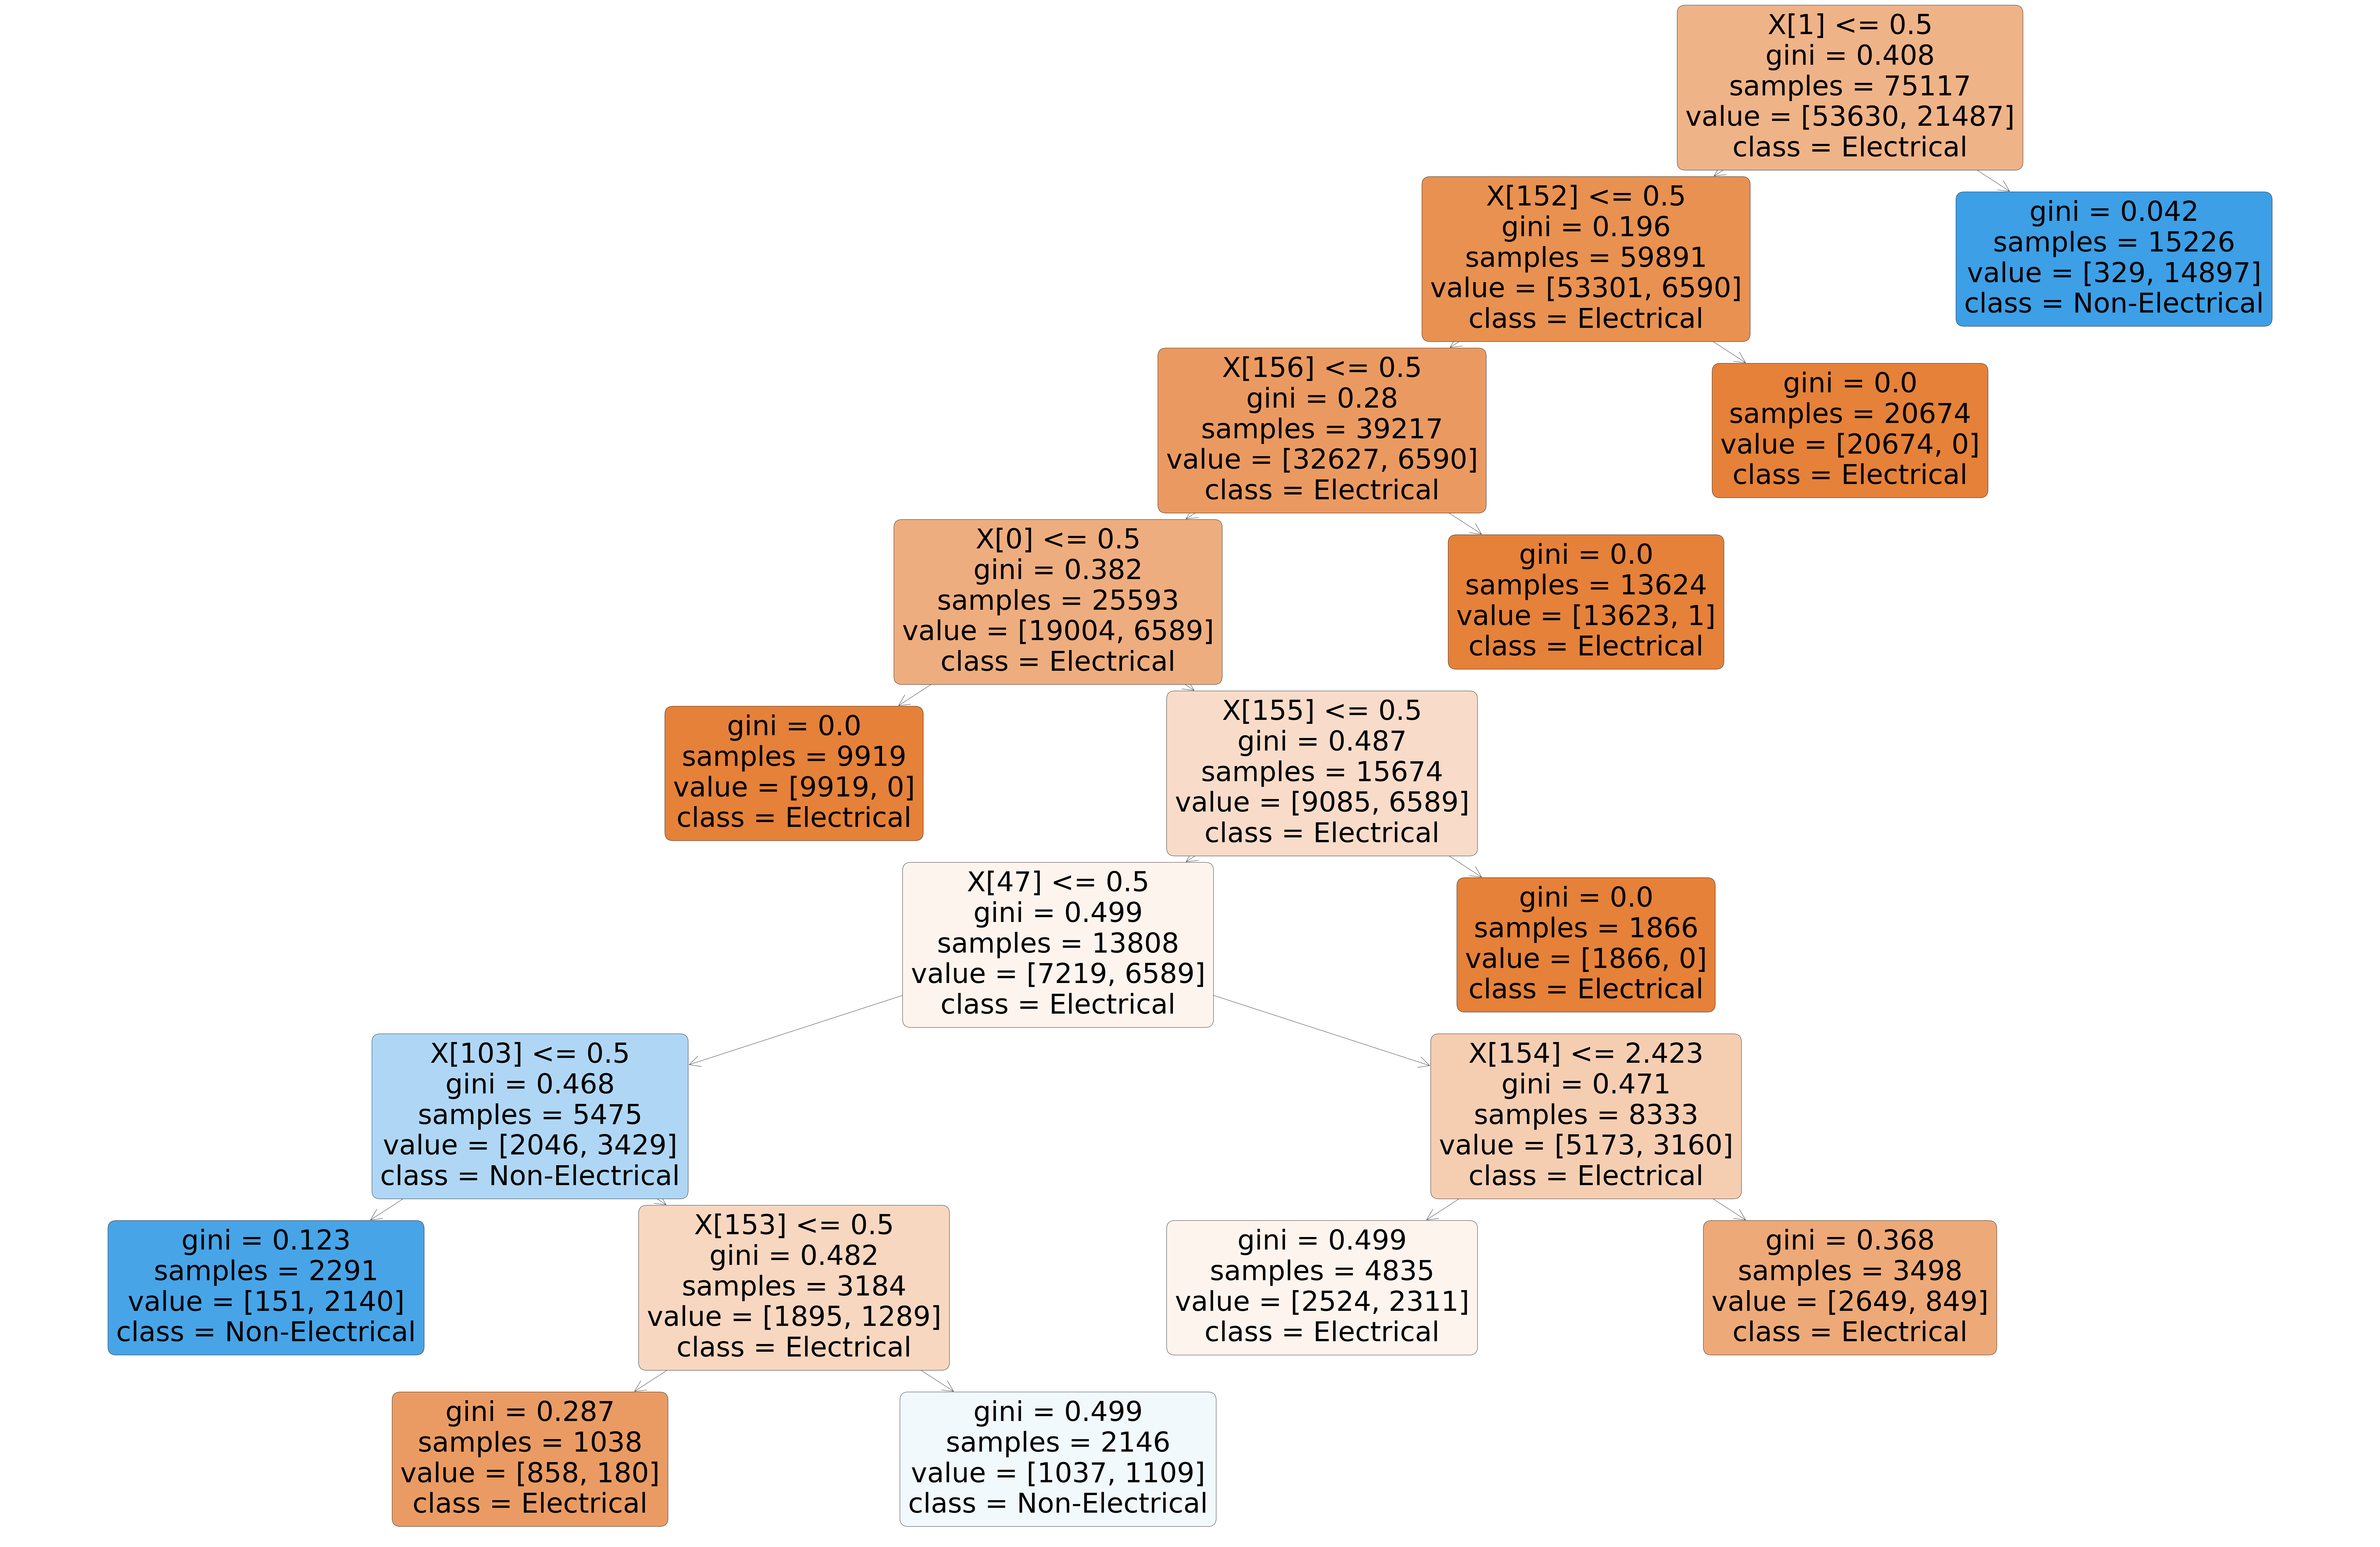

In [98]:
plt.figure(figsize=(150, 100))
plot_tree(classifier_pruned,
          filled=True,
          rounded=True,
          class_names=['Electrical', 'Non-Electrical'])

plt.show()

# 3. Hyper-parameter Tuning with RandomizedSearchCV

In [124]:
import timeit
from sklearn.model_selection import RandomizedSearchCV

start = timeit.default_timer()

classifier = DecisionTreeClassifier(random_state=10)

# Round 1
param_grid = {
    'max_depth': [10, 30, 70],
    'min_samples_split': [1000, 3000, 5000],
    'splitter': ['best', 'random'],
    'criterion': ['gini', 'entropy']
}

# Runtime:  49.7264851660002
# Best Accuracy: 99.04 %
# Best Parameters:  {
#                    'splitter': 'best', 
#                    'min_samples_split': 1000, 
#                    'max_depth': 30, 
#                    'criterion': 'entropy'
#                   }


# Round 2
# param_grid = {
#     'max_depth': [70, 100],
#     'min_samples_split': [500, 700, 1000],
#     'splitter': ['best'],
#     'criterion': ['entropy']
# }

optimal_params = RandomizedSearchCV(
    estimator=classifier,
    param_distributions=param_grid, 
    cv=5,
    n_iter=30,
    scoring='roc_auc')

optimal_params.fit(X_train, y_train)
best_accuracy = optimal_params.best_score_
best_parameters = optimal_params.best_params_
stop = timeit.default_timer()

print("Runtime: ", stop-start)
print('Best Accuracy: {:.2f} %'.format(best_accuracy*100))
print("Best Parameters: ", best_parameters)

Runtime:  94.92924165300792
Best Accuracy: 99.04 %
Best Parameters:  {'splitter': 'best', 'min_samples_split': 1000, 'max_depth': 70, 'criterion': 'entropy'}


In [125]:
optimized_classifier = DecisionTreeClassifier(
    max_depth=70,
    splitter='best',
    min_samples_split=1000,
    criterion='entropy',
    random_state=10
)

optimized_classifier = optimized_classifier.fit(X_train, y_train)

In [126]:
dp.get_scores(optimized_classifier, X_val, y_val, X_test, y_test)

Validation Set Metrics: 
-----------------------
Confusion matrix: 
 [[17134   743]
 [  606  6556]]

F1 Score:  0.9067146117142659

Precision:  0.898205233593643

Accuracy:  0.9461240464874795

Recall/Sensitivity:  0.9153867634738899

Specificity:  0.9584382167030262


Test Set Metrics: 
-----------------
Confusion matrix: 
 [[13852  4366]
 [ 4006  2924]]

F1 Score:  0.4112517580872011

Precision:  0.40109739368998626

Accuracy:  0.6670908223317957

Recall/Sensitivity:  0.42193362193362194

Specificity:  0.7603469096497969
